# Introduction

Sweet Lift Taxi Company wishes to attract more drivers during peak hours. They have offered historical data on taxi orders at airports to find a model that predicts the amount of taxi orders needed for the next hour.

## Data description

The data is stored in file `taxi.csv`. It contains two columns:
- `num_orders` - the number of taxi orders at the airport
- `datetime` - the date and time when the orders are made

## Procedure

Creating a model requires three main steps:

 - Data Preparation: data is imported and checked for general errors.
- Data Analysis: data is checked for stationarity through decomposition, moving average tracking and the ad-fuller test.
- Model Training: Models are fitted and predictions scored based on the root-mean-square-error metric (RMSE). The best model is chosen and used on the test set.

Each will be discussed in more depth at each stage. 

# Preparation

To prepare the data, packages must first be imported along with those that will help the analysis and training portions of the project. Data is then read in and checked for odd and missing values.

In [2]:
import pandas as pd  # for data manipulation
import numpy as np  # for numerical computation
import matplotlib.pyplot as plt  # for data visualization
import plotly.express as px  # for data visualization
import plotly.graph_objects as go  # for data visualization
import warnings # for ignoring warnings

from statsmodels.tsa.seasonal import seasonal_decompose  # to decompose the time series into components
from statsmodels.tsa.stattools import adfuller  # for checking stationarity
from statsmodels.tsa.ar_model import ar_select_order  # for finding lags

from sklearn.model_selection import train_test_split  # for splitting the data into sets
from sklearn.metrics import mean_squared_error  # for evaluating models
from sklearn.linear_model import LinearRegression  # for linear regression model
from sklearn.model_selection import GridSearchCV  # for hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit  # for time series cross validation
from sklearn.ensemble import RandomForestRegressor  # for random forest model

import xgboost as xgb  # for gradient boosting regression
from pmdarima import auto_arima  # for finding the best ARIMA model


In [3]:
# Load the data, parse dates on the datetime column
df = pd.read_csv('data/taxi.csv', parse_dates=['datetime'])

In [4]:
# resample by one hour
df = df.resample('1h', on='datetime').sum()

In [5]:
# display head
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Values Check

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
# display summary statistics
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


No values are missing. Summary statistics show that minimum and maximum values exist at 0 and 462 respectively. This is reasonable as no negative values should exist. The median is at 78, whilst the mean is at 84. This suggests the data is right-skewed.

# Analysis

The analysis will mostly focus on whether the data is stationary or not as this will impact which models will be most efficient. An initial look at data will be taken to see if any clear trends or seasonality occurs. Decompositional tools will be used in conjunction with a moving average graph and the ad-fuller test to do so.

### General Check

In [8]:
# filter warnings specific to datetime
warnings.filterwarnings("ignore", message="The behavior of DatetimeProperties.to_pydatetime is deprecated")


# show lineplot
fig = px.line(df, x=df.index, y='num_orders', title='Number of Taxi Orders by Hour')

# change color of plot to hotpink
fig.update_traces(line_color='hotpink')

# change x axis mean number of orders by hour
fig.update_layout(xaxis_title='Hour', yaxis_title='Number of Orders')

# show plot
fig.show()

Throughout the year taxi rides seem to increase with higher floors and peaks. If so, the data may not be considered stationary which will mean that certain models may not be appropriate to use. This will be further checked with decompostional tools followed by the ad-fuller test.

### Decompositional Tools

The dataframe will be broken into three components: trend, seasonality, and noise. The trend is the overall direction of the data, the seasonality is the repeating pattern, and the noise is the random variation in the data.

In [9]:
# Decompose the time series over a 24 hour period
decomposition = seasonal_decompose(df['num_orders'], model='additive', period=24)

# Extract decomposition components
trend = decomposition.trend
residual = decomposition.resid

In [50]:
# create function to plot the decomposition components
def plot_decomposition(decompositional_element):    
    # Plot the trend component
    fig = go.Figure()

    # Plot trend component with hotpink color
    fig.add_trace(go.Scatter(x=df.index, y=decompositional_element, mode='lines', line=dict(color='hotpink'), name='Trend'))

    # Update layout
    # capitalize the first letter of the title
    fig.update_layout(title=decompositional_element.name.capitalize()+' Component',
                    xaxis_title='Date',
                    yaxis_title=decompositional_element.name)

    # Show figure
    return fig.show()

Trend analysis suggests that the number of taxi orders is increasing over time.

In [51]:
# plot the trend component
plot_decomposition(trend)

In [52]:
# take slice of the data
slice = df['2018-08-01':'2018-08-03']

# find seasonality of slice
decomposition = seasonal_decompose(slice['num_orders'], model='additive', period=24)

# Extract decomposition components
seasonality = decomposition.seasonal

# plot the seasonal component
plot_decomposition(seasonality)


Seasonality suggests rides peak at 4am and drop dramatically at 9am. Rides start to increase at 12pm until 2pm. A significant rise occurs again at 8pm until falling back down at 10pm. Rides increase at around midnight and see a sharp rise at 3am.

The early morning increase in rides could be explained by the lack of transportation available to airport users. Spikes seen around 8pm could be explained by an increase in people touching down in the airport after work hours. These are all theories, however what is clear is that seasonality exists.

In [13]:
# Repeat for residual component
residual = decomposition.resid

# Plot the residual component
fig = go.Figure()

# Plot residual component with hotpink color
fig.add_trace(go.Scatter(x=df.index, y=residual, mode='lines', line=dict(color='hotpink'), name='Residual'))

# Update layout
fig.update_layout(title='Residual Component',
                  xaxis_title='Date',
                  yaxis_title='Residual')

# Show figure
fig.show()

Residual data clearly exists.

### Moving Average Plot

A moving average plot will be created to identify trends more generally

In [14]:
#Source: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", alpha=0.5)
    plt.legend(loc="upper left")
    plt.grid(True)

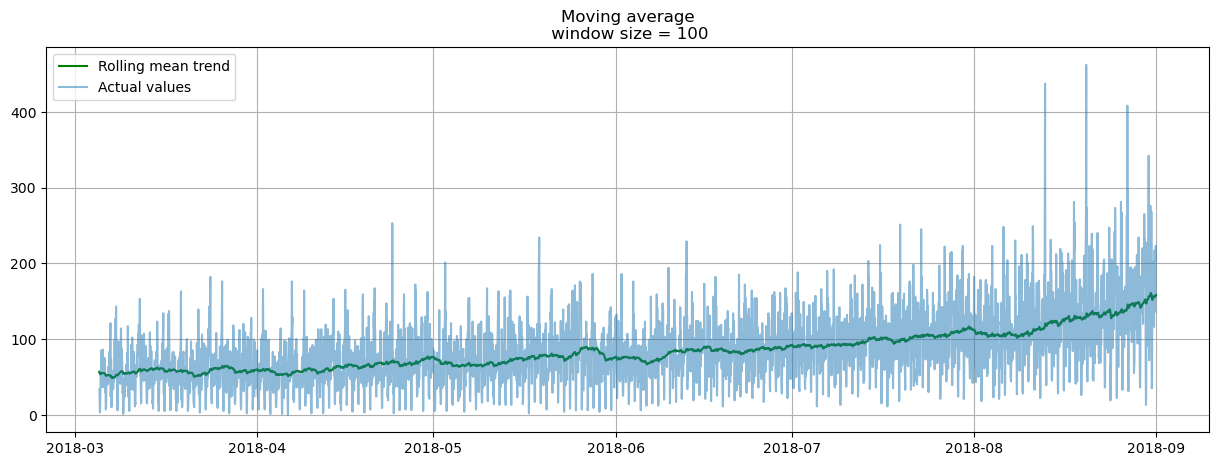

In [15]:
plotMovingAverage(df['num_orders'], 100)

From the graph, it is clear that the trend is moving in a positive direction.

### Adfuller Test

The ad-fuller test will determine how likely the data is stationary. A p-value is returned where results under 0.05 indicate that the data is likely stationary.

In [16]:
# run the adfuller test to check for stationarity
df_stationaritytest = adfuller(df, autolag='AIC')
print("P-value: ", df_stationaritytest[1])

P-value:  0.02894005140261486


As the p-value is below 0.05, data is likely stationary. Thus, Discrepencies exist between the results of decompositional and moving average data with the ad-fuller test. However, the ad-fuller test as a hypothetical test does not guarantee this outcome and the data will be treated as if it is not stationary. Thus models that do not account for trends and seasonality will not be used.

## Training

Training the model will include:
- Creating additional features such as lags, day, month and rolling mean and standard deviations
- Splitting data appropriately into training, validation, and test sets 
- Splitting data into features and targets
- Creating a sanity check or baseline to compare metrics with
- Training multiple models that incorporate:
    - Linear Regression
    - Random Forests
    - Gradient Boosting
    - Auto Arima Functioning (SARIMAX)
- Comparing RMSE values to ensure no overfitting occurs
- Choosing the best model
- Comparing test results of the best model with baseline results

### Additional Features

Lag features that are correlated to the number of taxi orders will be added. Day and month columns will be made. Rolling mean and standard deviations will also be added.

### Lag Features

As previous values may be predictive for future values, lag features should be added. To determine how many should be included, find those that are correlated within a 95% interval. Once lag features are added, find the rolling mean of these 

In [17]:
# find optimal number of lags
lags = ar_select_order(endog = df, maxlag=30)

# save optimal number of lags
ar_order = lags.ar_lags

# find max number of lags
max(ar_order)

28

In [18]:
# add 28 lags
for lag in range(1, 28):
    df[f'lag_{lag}'] = df['num_orders'].shift(lag)

#### Day and Month Features

In [19]:
# create hour feature
df['hour'] = df.index.hour

# create day feature
df['day'] = df.index.day

# # create day feature
df['day_of_week'] = df.index.dayofweek

# create month feature
df['month'] = df.index.month

#### Rolling Mean and Standard Deviation

Create columns based on the mean of the previous 24.

In [20]:
# find rolling mean of the time series
df['rolling_mean'] = df['num_orders'].shift().rolling(window=24).mean()

# find rolling standard deviation of the time series
df['rolling_std'] = df['num_orders'].shift().rolling(window=24).std()

# drop missing values
df.dropna(inplace=True)

### Split Data

Split the data into training, validation and testing sets. Afterwards split into the appropriate feature and target data. Ensure that shuffle is set to False to ensure data maintains its time-series ordering.

In [21]:
# split the data into train, validation and test sets
train_valid, test = train_test_split(df, test_size=0.1, shuffle=False)

# split the validation and test sets
train, valid = train_test_split(train_valid, test_size=0.1, shuffle=False)

# create function to seperate functions into features and target
def separate_features_target(data):
    # create features
    X = data.drop('num_orders', axis=1)
    # create target
    y = data['num_orders']
    return X, y

# seperate features and target for train, validation and test sets
X_train, y_train = separate_features_target(train)
X_valid, y_valid = separate_features_target(valid)
X_test, y_test = separate_features_target(test)

### Sanity Check

Before training takes place, a benchmark will be calculated to help satisfy a sanity check. This will be done by setting all values to the median aswell as using previous values to predict the next value.

#### Median 

Set all target values to the median value of the training set. Find the root mean squared error of this set to the validation set.

In [22]:
# create a test array that saves the median of the target of the training set
pred_median = np.full(len(y_valid), y_train.median())

#create a function to calculate the RMSE of a model
def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred) ** 0.5, 2)

# print the RMSE of the median model
print('RMSE:', rmse(y_valid, pred_median))

RMSE: 58.86


#### Previous Values

In [23]:
# shift the training set by 1
pred_previous = y_valid.shift()

# drop missing values
pred_previous.dropna(inplace=True)

# save the RMSE of the previous values model
rmse_prev = rmse(y_valid[1:], pred_previous)

# print the RMSE of the previous valuesmodel
print('RMSE:', rmse_prev)

RMSE: 46.82


As the previous values model has a lower RMSE, we will use it as the baseline model to compare with others.

### Linear Regression


In [24]:
# create linear regression model
lr = LinearRegression()

# fit the model
lr.fit(X_train, y_train)

# make predictions
pred_train = lr.predict(X_train)
pred_valid = lr.predict(X_valid)

# print the RMSE of the linear regression models
print('RMSE train:', rmse(y_train, pred_train))
print('RMSE validation:', rmse(y_valid, pred_valid))

RMSE train: 24.34
RMSE validation: 33.98


Linear regression shows a lower RMSE than the previous values model and the median model at 33.98 on the validation set.

In [25]:
# create function to plot the difference between the actual and predicted values
def residuals_plot(y_true, y_pred):
    # calculate residuals
    residuals = np.abs(y_true - y_pred)
    # plot residuals
    fig = px.histogram(residuals, title='Residuals of Random Forest Model')
    # change color of plot to hotpink
    fig.update_traces(marker_color='hotpink')
    # replace legend
    fig.update_layout(showlegend=False)
    # show plot
    fig.show()

### Random Forest

In [26]:
# create hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': range(3, 10, 1),
    'min_samples_split': range(2, 5),  # Adjusted range
    'min_samples_leaf': range(1, 4),
}

# set the time series split
tscv = TimeSeriesSplit(n_splits=5)

# create random forest model
model = RandomForestRegressor(random_state=42)

# create grid search
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=tscv, 
                           n_jobs=-1, 
                           scoring='neg_mean_squared_error',)

# fit the grid search
grid_search.fit(X_train, y_train)

# make predictions
pred_train = grid_search.predict(X_train)
pred_valid = grid_search.predict(X_valid)

# print the RMSE of the random forest model
print('Best_params:', grid_search.best_params_)
print('RMSE train:', rmse(y_train, pred_train))
print('RMSE validation:', rmse(y_valid, pred_valid))


Best_params: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
RMSE train: 15.25
RMSE validation: 32.76


The best model was found with a depth of 9, min leaves of 2, min split of 2, and using 200 estimators.

RMSE on the train set gave an RMSE of 15.25, compared to 32.76 on the validation set. This difference between values may show signs of overfitting. A direct comparison of predicted and actual values along with an analysis on residuals may reveal more.

In [27]:
# create function to plot actual and predicted values
def plot_actual_predicted(y_true, y_pred):
    # create figure
    fig = go.Figure()
    # plot actual values
    fig.add_trace(go.Scatter
                    (x=y_true.index, y=y_true, mode='lines', line=dict(color='blue'), name='Actual'))
    # plot predicted values
    fig.add_trace(go.Scatter
                    (x=y_true.index, y=y_pred, mode='lines', line=dict(color='hotpink'), name='Predicted'))
    
    # Update layout
    fig.update_layout(title='Actual vs Predicted Values',
                      xaxis_title='Date',
                      yaxis_title='Number of Orders')
    
    # Show figure
    fig.show()
    
# plot actual and predicted values
plot_actual_predicted(y_valid, pred_valid)

In [28]:
# create function to plot residuals
def residuals_plot(y_valid, pred_valid):
    # calculate residuals
    residuals = np.abs(y_valid - pred_valid)
    # plot residuals
    fig = px.histogram(residuals, title='Residuals of Random Forest Model')
    # change color of plot to hotpink
    fig.update_traces(marker_color='hotpink')
    # replace legend
    fig.update_layout(showlegend=False)
    # show plot
    fig.show()
    
# plot residuals
residuals_plot(y_valid, pred_valid)

Whilst the random forest model has a low RMSE score, this model will not be used due to overfitting. This is due to major discrepencies between predicted and actual values being present such as those seen on August 13th.

### Gradient Boosting



In [29]:
# use xgboost to create a model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# fit the model
xg_reg.fit(X_train, y_train)

# make predictions
pred_train = xg_reg.predict(X_train)
pred_valid = xg_reg.predict(X_valid)

# print the RMSE of the xgboost model
print('RMSE train:', rmse(y_train, pred_train))
print('RMSE validation:', rmse(y_valid, pred_valid))

RMSE train: 25.89
RMSE validation: 43.71


These RMSE values of 25.9 and 43.7 for both the train and validation sets are not as good as the linear regression model. Signs of overfitting may also exist.

### Auto ARIMA models

The auto arima function will be used to consider other models that may produce better results.

In [30]:
# find optimal model for our data
model = auto_arima(y_train, seasonal=True, m=24, scoring='mse')

# make predictions
pred_train = model.predict_in_sample()
pred_valid = model.predict(n_periods=len(y_valid))

# calculate RMSE
print('RMSE train:', rmse(y_train, pred_train))
print('RMSE valid:', rmse(y_valid, pred_valid))

# print summary
model.summary()

RMSE train: 26.92
RMSE valid: 95.03


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3555
Model:             SARIMAX(5, 1, 0)x(1, 0, 0, 24)   Log Likelihood              -16741.263
Date:                            Thu, 21 Mar 2024   AIC                          33496.526
Time:                                    14:38:43   BIC                          33539.757
Sample:                                03-02-2018   HQIC                         33511.942
                                     - 07-28-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6476      0.015    -43.683      0.000      -0.677      -0.619
ar.L2         -0.4266      0.018    -23.597      0.000      -0.462      -0.391
ar.L3         -0.3026      0.019    -16.047      0.000      -0.340      -0.266
ar.L4         -0.2023      0.019    -10.772      0.000      -0.239      -0.165
ar.L5         -0.1041      0.016     -6.564      0.000      -0.135      -0.073
ar.S.L24       0.5762      0.013     43.564      0.000       0.550       0.602
sigma2       720.7686     13.579     53.080      0.000     694.154     747.383
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):               283.26
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A SARIMAX model found a training RMSE of 26.9, however, was far off when predicting the validation set at 72.2. This is the worst result yet and so will not be used.

## Testing

The model that returned the best result was the linear regression model. This model will be used to find the overall RMSE value of the test set. A new version of the model will be used that combines the training and validation sets.

In [31]:
# combine training and validation sets
train_valid = pd.concat([train, valid])

# save features and target
X_tv, y_tv = separate_features_target(train_valid)

In [32]:
# create linear regression model
lr = LinearRegression()

# fit the model
lr.fit(X_tv, y_tv)

# make predictions
pred_train_valid = lr.predict(X_tv)
pred_test = lr.predict(X_test)


# print the RMSE of the linear regression models
print('RMSE train_valid:', rmse(y_tv, pred_train_valid))
print('RMSE test:', rmse(y_test, pred_test))

RMSE train_valid: 25.42
RMSE test: 46.16


The linear regression model returned an RMSE of 46.11 on the test set. This is slightly better than the RMSE of the previous values model on the validation set. Thus, it is difficult to say if the model is infact better than simply looking to previous values.

# Conclusion

## Preparation

The data was prepared by resampling data by each hour and adding the number of taxi orders. Values were checked to ensure no oddities or missing data was present. The data was analysed to determine if it was stationary. This was done by decomposing the data, checking the rolling mean and using the ad-fuller test. Although results differed, the data was found to be not stationary

## Training

The data was trained on multiple models. These included:

- Linear Regression
- Random Forests
- Gradient Boosting
- SARIMAX

Although random forests produced smaller RMSE values on training and validation sets, the data was found to be overfit. Instead the linear regression model produced the next best values without overfitting data.

### Testing

The linear regression model was used to predict values on the test set. Results yielded an RMSE value slightly better than the previous models result. Thus it is difficult to say that the model performed any better than simply predicting the previous value.